# Bank Marketing Campaign Classification: A Deep Learning Approach

## Project Overview

This project aims to build and evaluate machine learning models to predict the outcome of a direct marketing campaign by a Portuguese banking institution. The dataset, sourced from the UCI Machine Learning Repository, contains client and campaign attributes, with the goal of predicting whether a client will subscribe to a term deposit (`y`: yes/no). The workflow covers data loading, preprocessing, feature selection, handling class imbalance, model building with PyTorch, and performance evaluation using various resampling techniques.

---

## Table of Contents

1. [Introduction](#introduction)
2. [Data Loading and Exploration](#data-loading-and-exploration)
3. [Data Preprocessing](#data-preprocessing)
4. [Feature Selection](#feature-selection)
5. [Handling Class Imbalance](#handling-class-imbalance)
6. [Model Building](#model-building)
7. [Model Training and Evaluation](#model-training-and-evaluation)
8. [Resampling Techniques](#resampling-techniques)
    - [SMOTE Oversampling](#smote-oversampling)
    - [Undersampling](#undersampling)
9. [Results and Discussion](#results-and-discussion)
10. [Conclusion and Implications](#conclusion-and-implications)

---

## Introduction

Direct marketing campaigns are widely used in the banking sector to promote financial products. However, predicting customer response is challenging due to the inherent class imbalance—most clients do not subscribe to the product. This project leverages deep learning and advanced resampling techniques to address this challenge, aiming for fair and effective classification.

---

## Data Loading and Exploration

- **Dataset Source:** UCI Machine Learning Repository (Bank Marketing Dataset, ID: 222).
- **Features:** Includes demographic (age, job, marital, education), financial (balance, loan, housing), and campaign-related (duration, contact, month, day_of_week, pdays, campaign) attributes.
- **Target Variable:** `y` (binary: yes/no).

Initial steps:
- Import necessary libraries (PyTorch, pandas, scikit-learn, imbalanced-learn, etc.).
- Fetch and inspect the dataset, including metadata and variable descriptions.
- Combine features and target into a single DataFrame for easier manipulation.
- Explore data structure, types, and target distribution.

---

## Data Preprocessing

- **Null Value Handling:** 
    - Columns with >30% missing values are dropped.
    - Numerical columns with missing values are filled with the median.
    - Categorical columns with missing values are filled with the mode.
- **Feature Type Separation:** 
    - Numerical and categorical features are separated for tailored preprocessing.
- **Encoding and Scaling:** 
    - Numerical features are scaled using `StandardScaler`.
    - Categorical features are encoded using `LabelEncoder`.

---

## Feature Selection

- **Importance Analysis:** 
    - XGBoost is used to determine feature importance.
    - Features with low importance or redundancy (e.g., `day_of_week`, `contact`, `pdays`) are considered for removal.
- **Selected Features:** 
    - A subset of features is chosen based on importance and domain knowledge, including `duration`, `balance`, `month`, `job`, `campaign`, `education`, `housing`, `marital`, `loan`, `age`, and the target `y`.

---

## Handling Class Imbalance

- **Problem:** 
    - The target variable is highly imbalanced, with far fewer positive (`yes`) responses.
- **Visualization:** 
    - Class distribution is visualized using Seaborn's `countplot`.
- **Approaches:** 
    - Both oversampling (SMOTE) and undersampling techniques are explored to balance the classes before model training.

---

## Model Building

- **Architecture:** 
    - A custom PyTorch neural network (`BankClassifier`) is defined with two hidden layers and a sigmoid output for binary classification.
- **Data Preparation:** 
    - Features and targets are split into training and test sets, then converted to PyTorch tensors.

---

## Model Training and Evaluation

- **Training:** 
    - The model is trained using binary cross-entropy loss and the Adam optimizer.
    - Early stopping is implemented to prevent overfitting.
- **Evaluation:** 
    - Performance is assessed using confusion matrix and classification report (precision, recall, F1-score, accuracy).
    - Initial results show strong performance on the majority class but poor detection of the minority class.

---

## Resampling Techniques

### SMOTE Oversampling

- **Synthetic Minority Over-sampling Technique (SMOTE):**
    - Generates synthetic samples for the minority class to balance the dataset.
    - Multiple random states are tested to find the best sampling configuration.
    - The balanced dataset is visualized and used to retrain the model.
    - Model performance improves on the minority class, with higher recall and F1-score.

### Undersampling

- **Random Undersampling:**
    - Reduces the majority class to match the minority class size.
    - The model is retrained on the undersampled dataset.
    - Improves minority class detection but may reduce overall accuracy due to loss of majority class data.

---

### Import libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
os.environ["SCIPY_ARRAY_API"] = "1"
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from ucimlrepo import fetch_ucirepo
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

### Load dataset

In [3]:
# Fetch dataset
dataset = fetch_ucirepo(id=222)
X = dataset.data.features
y = dataset.data.targets

# inspect the metadata nd the variables
print(dataset.metadata)
print(dataset.variables)

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [4]:
# combine the dataset fro easy preprocessing

df = pd.concat([X,y], axis=1)

# view the basic structure of the dataset
print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None
(45211, 17)
   age           job  marital  education def

In [5]:
# check the distribution of the target variable
df["y"].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

### Data Preprocessing

In [6]:
df["age"].head(10)

0    58
1    44
2    33
3    47
4    33
5    35
6    28
7    42
8    58
9    43
Name: age, dtype: int64

In [7]:
# check for null values in dataset

df.isnull().sum()

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64

In [8]:
# view the numerical variable and the categorical variables
num = df.select_dtypes(include='number')
cat = df.select_dtypes(exclude='number')

#view the respective datasets
print(f"Numerical Variables")
display(num.head())
print(f"Categorical Variables")
display(cat.head())

Numerical Variables


,age,balance,day_of_week,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0


Categorical Variables


,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,management,married,tertiary,no,yes,no,NaN,may,NaN,no
1,technician,single,secondary,no,yes,no,NaN,may,NaN,no
2,entrepreneur,married,secondary,no,yes,yes,NaN,may,NaN,no
3,blue-collar,married,NaN,no,yes,no,NaN,may,NaN,no
4,NaN,single,NaN,no,no,no,NaN,may,NaN,no


In [9]:
num["pdays"].value_counts()

pdays
-1      36954
 182      167
 92       147
 183      126
 91       126
        ...  
 749        1
 769        1
 587        1
 778        1
 854        1
Name: count, Length: 559, dtype: int64

In [10]:
# remove the columns with the most nll values and fill the rest with appropiate values
for col in df.columns:
    if (df[col].isnull().sum()/len(df)) * 100 < 30:
        if col in num.columns:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df.drop(col, axis=1, inplace=True)
        
# view the first 5 columns of the clean dataset
df.isnull().sum().head()

age          0
job          0
marital      0
education    0
default      0
dtype: int64

In [11]:
df.shape

(45211, 16)

- Encode the categorical columns and also Scale the numerical columns

In [12]:
#encode the categorical columns and scale teh numerical sets
scaler = StandardScaler()
encoder = LabelEncoder()

# scale the numerical sets
for col in num:
    if col in df.columns:
        df[col] = scaler.fit_transform(df[[col]])
        
# encode the categorical sets
for col in cat:
    if col in df.columns:
        df[col] = encoder.fit_transform(df[col])
        
# view the first five rows of the dataset
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,y
0,1.606965,4,1,2,0,0.256419,1,0,0,-1.298476,8,0.011016,-0.569351,-0.411453,-0.25194,0
1,0.288529,9,2,1,0,-0.437895,1,0,0,-1.298476,8,-0.416127,-0.569351,-0.411453,-0.25194,0
2,-0.747384,2,1,1,0,-0.446762,1,1,0,-1.298476,8,-0.707361,-0.569351,-0.411453,-0.25194,0
3,0.571051,1,1,1,0,0.047205,1,0,0,-1.298476,8,-0.645231,-0.569351,-0.411453,-0.25194,0
4,-0.747384,1,2,1,0,-0.447091,0,0,0,-1.298476,8,-0.233620,-0.569351,-0.411453,-0.25194,0


=- -We can now check the features of the most importance to be able to remove the columns that won't be needed in the classificationa and model building

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

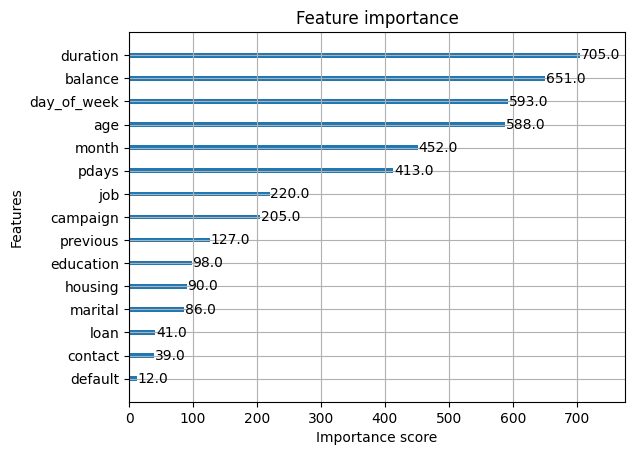

In [13]:
# using XGBooxt to find teh feature of importance
dx = df.drop('y', axis=1)
y = df['y']

import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(dx, y)

# print feature of importance scores
xgb.plot_importance(model)

- Columns deemed less important will be removed from the dataset. 
- Special consideration is given to removing "day_of_week" since the "duration" column already captures the length of contacts, making "day_of_week" potentially redundant. 
- Additionally, we will review related columns such as "contact" and "pdays" to determine if they provide unique information or if they can also be excluded.

In [14]:
sel_columns= ["duration", "balance", "month", "job",
                "campaign", "education", "housing", "marital", "loan", "age", "y"
                ]

# instatiate a new dataset with selected columns
df_new = df[sel_columns]
df_new.head()

,duration,balance,month,job,campaign,education,housing,marital,loan,age,y
0,0.011016,0.256419,8,4,-0.569351,2,1,1,0,1.606965,0
1,-0.416127,-0.437895,8,9,-0.569351,1,1,2,0,0.288529,0
2,-0.707361,-0.446762,8,2,-0.569351,1,1,1,1,-0.747384,0
3,-0.645231,0.047205,8,1,-0.569351,1,1,1,0,0.571051,0
4,-0.233620,-0.447091,8,1,-0.569351,1,0,2,0,-0.747384,0


In [15]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'y'],
      dtype='object')

### Build Model

<Axes: xlabel='y', ylabel='count'>

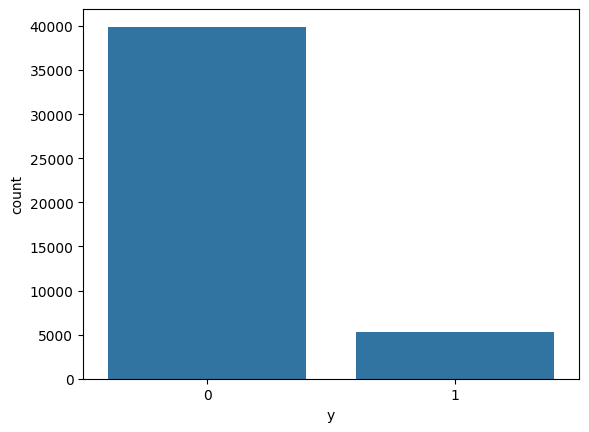

In [16]:
import seaborn as sns
sns.countplot(x=df_new.y)

- The target variable is highly imbalanced. To address this issue in the subsequent steps, I will apply both SMOTE (Synthetic Minority Over-sampling Technique) and undersampling methods to balance the target classes before model training.

In [17]:
# instantite the train and test variables
X= df_new.drop("y",axis=1)
y= df_new.y
# Split the dataset in to train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.20, random_state = 98, stratify = y)

In [18]:
# convert to Pytorch tensors
xtrain = torch.tensor(xtrain.to_numpy(), dtype=torch.float32)
xtest = torch.tensor(xtest.to_numpy(), dtype=torch.float32)
ytrain = torch.tensor(ytrain.to_numpy(), dtype=torch.float32).unsqueeze(1)
ytest = torch.tensor(ytest.to_numpy(), dtype=torch.float32).unsqueeze(1)

### Build model

In [19]:
# define the torch model class
class BankClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BankClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))
    
model = BankClassifier(xtrain.shape[1])

###Train the model and check the model performance on the imbalanced data

In [20]:
# Train model with Early stoppings
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stoppings
best_loss = float("inf")
patience = 5
trigger = 0

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(xtrain)
    loss = criterion(outputs, ytrain)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(xtest)
        val_loss = criterion(val_outputs, ytest)
        
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    
    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        trigger = 0
    else:
        trigger +=1
        if trigger >= patience:
            print("Early stopping triggered.")
            break

Epoch 1, Train Loss: 0.8639, Val Loss: 0.8330
Epoch 2, Train Loss: 0.8343, Val Loss: 0.8055
Epoch 3, Train Loss: 0.8066, Val Loss: 0.7794
Epoch 4, Train Loss: 0.7803, Val Loss: 0.7544
Epoch 5, Train Loss: 0.7551, Val Loss: 0.7303
Epoch 6, Train Loss: 0.7308, Val Loss: 0.7070
Epoch 7, Train Loss: 0.7072, Val Loss: 0.6842
Epoch 8, Train Loss: 0.6843, Val Loss: 0.6622
Epoch 9, Train Loss: 0.6621, Val Loss: 0.6408
Epoch 10, Train Loss: 0.6406, Val Loss: 0.6201
Epoch 11, Train Loss: 0.6198, Val Loss: 0.6002
Epoch 12, Train Loss: 0.5997, Val Loss: 0.5808
Epoch 13, Train Loss: 0.5802, Val Loss: 0.5622
Epoch 14, Train Loss: 0.5615, Val Loss: 0.5441
Epoch 15, Train Loss: 0.5433, Val Loss: 0.5266
Epoch 16, Train Loss: 0.5257, Val Loss: 0.5097
Epoch 17, Train Loss: 0.5088, Val Loss: 0.4937
Epoch 18, Train Loss: 0.4927, Val Loss: 0.4784
Epoch 19, Train Loss: 0.4774, Val Loss: 0.4641
Epoch 20, Train Loss: 0.4630, Val Loss: 0.4508
Epoch 21, Train Loss: 0.4497, Val Loss: 0.4386
Epoch 22, Train Loss: 

In [21]:
# Evaluate the Model
with torch.no_grad():
    y_pred = model(xtest)
    y_pred_class = (y_pred > 0.5).float()
    
print(confusion_matrix(ytest, y_pred_class))
print(classification_report(ytest, y_pred_class, target_names=["No", "Yes"]))

[[7943   42]
 [ 960   98]]
              precision    recall  f1-score   support

          No       0.89      0.99      0.94      7985
         Yes       0.70      0.09      0.16      1058

    accuracy                           0.89      9043
   macro avg       0.80      0.54      0.55      9043
weighted avg       0.87      0.89      0.85      9043



- model performs well on the majority class ("No") but very poorly on the minority class ("Yes"). This is a classic case of class imbalance, where accuracy is high but the model fails to detect the minority class (possibly the more important one in real-life scenarios like fraud detection, disease diagnosis, etc.)

### SMOTE Balance 

In [22]:
# To get the best random smapling state
score = []

# Loop over the random states
for i in range(100):
    smote = SMOTE(random_state=i, sampling_strategy= 'auto')
    X_resampled, y_resampled = smote.fit_resample(xtrain, ytrain)
    
    #convert teh resampled to tensors
    X_convert = torch.tensor(X_resampled, dtype=torch.float32)
    y_convert = torch.tensor(y_resampled, dtype=torch.float32).unsqueeze(1)
    
    # Define model, loss, optimizer
    model = BankClassifier(X_convert.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train for a few Epochs
    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(X_convert)
        loss = criterion(outputs, y_convert)
        loss.backward()
        optimizer.step()
        
    # Evaluate (round the sigmoid outputs to 0 or 1)
    model.eval()
    with torch.no_grad():
        predictions = model(X_convert)
        predicted_labels = (predictions >0.5).float()
        acc = accuracy_score(y_convert.numpy(), predicted_labels.numpy())
        score.append(acc)
        
best_state = np.argmax(score)
print(f"Highest Accuracy: {score[best_state]:.4f} at random_state={best_state}")


Highest Accuracy: 0.8318 at random_state=40


<Axes: xlabel='y', ylabel='count'>

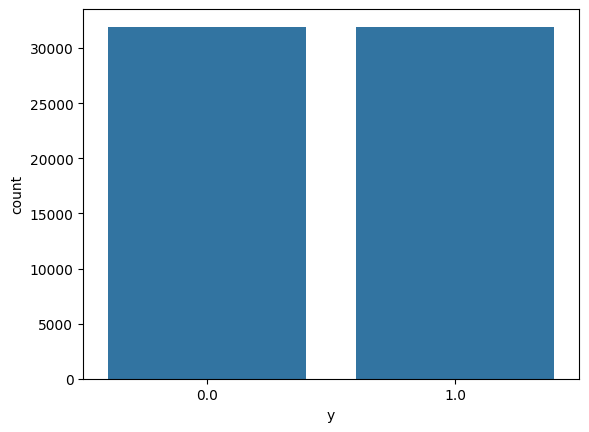

In [27]:
# convert the tensors to numpy so as to view if the data us finally balanced
xtrain_np = xtrain.numpy()
ytrain_np = ytrain.numpy().squeeze()

# replace the columns with column names
column_names = [f"feature_{i}" for i in range(xtrain_np.shape[1])]

# convert back to dataframe and series
X_res_data = pd.DataFrame(xtrain_np, columns=column_names)
y_res_data = pd.Series(ytrain_np, name='y')

# Apply smote to the dataset
smote = SMOTE(sampling_strategy='auto', random_state=40)
X_resampled, y_resampled = smote.fit_resample(X_res_data, y_res_data)

# Convert resampled data to DataFrame and Series
X_res_df = pd.DataFrame(X_resampled, columns=column_names)
y_res_df = pd.Series(y_resampled, name='y')

# concatinate teh two resampled dataframe
new_balanced_data = pd.concat([X_res_df, y_res_df], axis=1)

# view the target variable to see if its balanced
sns.countplot(x=new_balanced_data['y'])

In [28]:
# Prepare tensors from the resampled data
X_res_tensor = torch.tensor(X_res_df.values, dtype=torch.float32)
y_res_tensor = torch.tensor(y_res_df.values, dtype=torch.float32).unsqueeze(1)

# Initialize a new model
model_resampled = BankClassifier(X_res_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model_resampled.parameters(), lr=0.001)

# Train the model
epochs = 100
for epoch in range(epochs):
    model_resampled.train()
    
    #instatiate the optimizer, loss and criterion
    optimizer.zero_grad()
    outputs = model_resampled(X_res_tensor)
    loss = criterion(outputs, y_res_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/100, Loss: 0.6999
Epoch 10/100, Loss: 0.6755
Epoch 20/100, Loss: 0.6503
Epoch 30/100, Loss: 0.6155
Epoch 40/100, Loss: 0.5722
Epoch 50/100, Loss: 0.5279
Epoch 60/100, Loss: 0.4947
Epoch 70/100, Loss: 0.4758
Epoch 80/100, Loss: 0.4652
Epoch 90/100, Loss: 0.4572
Epoch 100/100, Loss: 0.4503


### Evaluate the model the newly balanced data


In [36]:
# Evaluate model_resampled on the test set
model_resampled.eval()
with torch.no_grad():
    y_pred_res = model_resampled(xtest)
    y_pred_binary = (y_pred_res > 0.5).float()

print(confusion_matrix(ytest, y_pred_binary))
print(classification_report(ytest, y_pred_binary, target_names=["No", "Yes"]))

[[6257 1728]
 [ 226  832]]
              precision    recall  f1-score   support

          No       0.97      0.78      0.86      7985
         Yes       0.33      0.79      0.46      1058

    accuracy                           0.78      9043
   macro avg       0.65      0.78      0.66      9043
weighted avg       0.89      0.78      0.82      9043



### Trying out undersampling techniques to see how much improvemnt the model has

In [40]:
df_new.head()

,duration,balance,month,job,campaign,education,housing,marital,loan,age,y
0,0.011016,0.256419,8,4,-0.569351,2,1,1,0,1.606965,0
1,-0.416127,-0.437895,8,9,-0.569351,1,1,2,0,0.288529,0
2,-0.707361,-0.446762,8,2,-0.569351,1,1,1,1,-0.747384,0
3,-0.645231,0.047205,8,1,-0.569351,1,1,1,0,0.571051,0
4,-0.233620,-0.447091,8,1,-0.569351,1,0,2,0,-0.747384,0


In [41]:
# convert tensors back to numpy and then dataframe for easy manipulation
xtrain_np = xtrain.numpy()
ytrain_np = ytrain.numpy().squeeze()


column_names = [f"feature_{i}" for i in range(xtrain_np.shape[1])]
df_full = pd.DataFrame(xtrain_np, columns=column_names)
df_full["y"] = ytrain_np

In [42]:
# undersample the majority class ("No" is class_0 and "Yes" is class_1)
class_0 = df_full[df_full['y'] == 0]
class_1 = df_full[df_full['y'] == 1]

class_0_under = class_0.sample(n=6200, random_state=42) # undersample the 0 class down to 6200
new_df = pd.concat([class_0_under, class_1], axis=0).sample(frac=1, random_state=42) # further shuffle the dataset

# seperarte back to Target and Features again
X_under = new_df.drop("y", axis=1)
y_under = new_df.y

# convert back to Tensor
X_under_tensor = torch.tensor(X_under.values, dtype=torch.float32)
y_under_tensor = torch.tensor(y_under.values, dtype=torch.float32).unsqueeze(1)


In [43]:
# Initialize and train a new model
model_under = BankClassifier(X_under_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model_under.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model_under.train()
    optimizer.zero_grad()
    outputs = model_under(X_under_tensor)
    loss = criterion(outputs, y_under_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate on the test set
model_under.eval()
with torch.no_grad():
    y_pred_under = model_under(xtest)
    y_pred_under_binary = (y_pred_under > 0.5).float()

print(confusion_matrix(ytest, y_pred_under_binary))
print(classification_report(ytest, y_pred_under_binary, target_names=["No", "Yes"]))

Epoch 1/100, Loss: 0.7456
Epoch 1/100, Loss: 0.7456
Epoch 10/100, Loss: 0.6682
Epoch 10/100, Loss: 0.6682
Epoch 20/100, Loss: 0.6399
Epoch 20/100, Loss: 0.6399
Epoch 30/100, Loss: 0.6115
Epoch 30/100, Loss: 0.6115
Epoch 40/100, Loss: 0.5789
Epoch 40/100, Loss: 0.5789
Epoch 50/100, Loss: 0.5440
Epoch 50/100, Loss: 0.5440
Epoch 60/100, Loss: 0.5132
Epoch 60/100, Loss: 0.5132
Epoch 70/100, Loss: 0.4927
Epoch 70/100, Loss: 0.4927
Epoch 80/100, Loss: 0.4791
Epoch 80/100, Loss: 0.4791
Epoch 90/100, Loss: 0.4701
Epoch 90/100, Loss: 0.4701
Epoch 100/100, Loss: 0.4633
Epoch 100/100, Loss: 0.4633
[[6707 1278]
 [ 309  749]]
              precision    recall  f1-score   support

          No       0.96      0.84      0.89      7985
         Yes       0.37      0.71      0.49      1058

    accuracy                           0.82      9043
   macro avg       0.66      0.77      0.69      9043
weighted avg       0.89      0.82      0.85      9043



# Conclusion and Implications

Three models were built:
1. Model trained on the original imbalanced data.
2. Model trained on SMOTE-balanced data (oversampling the minority class).
3. Model trained on undersampled data (reducing the majority class).

Findings:
- The original model performed well on the majority class but poorly on the minority class, as shown by low recall and F1-score for the minority.
- SMOTE improved the model's ability to detect the minority class, increasing recall and F1-score, but may introduce synthetic noise if not tuned properly.
- Undersampling balanced the classes by reducing the majority class, which improved minority class detection but at the cost of discarding potentially useful data, possibly reducing overall accuracy.

Implications:
- SMOTE is effective for handling class imbalance without losing data, but care must be taken to avoid overfitting to synthetic samples.
- Undersampling is simple and effective but may result in loss of information from the majority class.
- For imbalanced datasets, using resampling techniques like SMOTE or undersampling is crucial for building fair and effective classifiers, especially when the minority class is of high importance.
